
# Laboratório: DW de Saúde Pública — COVID‑19 (Brasil)

**Tema:** Saúde Pública (COVID‑19)  
**Bases:**  
1) **OWID COVID** (casos/óbitos por país) — CSV público  
2) **OWID Vaccinations** (vacinação por país) — CSV público  
3) **BrasilAPI Feriados** (enriquecimento de `dim_date` com `is_holiday`)

> Objetivo: consolidar dados diários de COVID e vacinação para o Brasil em um **DW (Star Schema)**, realizar **ETL** com pandas e aplicar **clustering** para segmentar períodos epidemiológicos.



## Bases (links)
- OWID COVID: `https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv`  
- OWID Vaccinations: `https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv`  
- BrasilAPI (feriados por ano): `https://brasilapi.com.br/api/feriados/v1/{ANO}`

> Se a internet estiver bloqueada, baixe os CSVs e coloque ao lado do notebook.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline
# OUT_DIR = Path("dw_health_output_aula")
OUT_DIR = Path("/content/drive/MyDrive/UFMS/Aulas/2025-2/SIAD/repo/SIAD-2025-02/dw_health_output_aula")
OUT_DIR.mkdir(exist_ok=True)



## Modelo conceitual (Star Schema)

Fato **`fact_covid_daily`** (granularidade: **dia-país**):  
**Chaves:** `date_sk`, `location_sk`  
**Medidas:** `new_cases`, `new_deaths`, `new_vaccinations`, `people_fully_vaccinated`, `stringency_index` (quando disponível)

Dimensões:  
- **`dim_date`**: `date_sk`, `date`, `year`, `month`, `day`, `is_holiday`  
- **`dim_location`**: `location_sk`, `iso_code`, `location`, `continent`, `population`, `population_density`


<pre style="font-size:13px; white-space:pre; overflow-x:auto;">
                   +-------------------+
                   |     dim_date      |
                   +-------------------+
                   | date_sk (PK)      |
                   | date              |
                   | year              |
                   | month             |
                   | day               |
                   | is_holiday        |
                   +-------------------+
                          |
                          | (FK)
                          |
+-------------------+     |     +-------------------+
|  dim_location     |     |     |  fact_covid_daily |
+-------------------+     |     +-------------------+
| location_sk (PK)  |-----+-----| date_sk (FK)      |
| iso_code          |           | location_sk (FK)  |
| location          |           | new_cases         |
| continent         |           | new_deaths        |
| population        |           | new_vaccinations  |
| population_density|           | people_fully_vacc |
+-------------------+           | stringency_index  |
                                +-------------------+
</pre>

In [3]:
def read_csv_web_or_local(url):
    fname = Path(url.split("/")[-1])
    full_output = OUT_DIR / fname

    if full_output.exists():
        print("✔ Lido do cache:", full_output)
        return pd.read_csv(full_output)

    else:
        print("✔ Lido da web:", url)
        try:
            df = pd.read_csv(url)
            print("✔ Lido da web:", url)
            if not full_output.exists():
                df.to_csv(full_output, index=False)
            return df
        except Exception as e:
            print("Web falhou:", e)

OWID_COVID = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
OWID_VAX = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"

covid = read_csv_web_or_local(OWID_COVID)
vax = read_csv_web_or_local(OWID_VAX)

covid.shape, vax.shape

✔ Lido da web: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
✔ Lido da web: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
✔ Lido da web: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv
✔ Lido da web: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv


((429435, 67), (196246, 16))

In [4]:
covid.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [5]:
vax.columns

Index(['location', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'daily_vaccinations_per_million', 'daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred'],
      dtype='object')

In [6]:
covid.dtypes

,0
iso_code,object
continent,object
location,object
date,object
total_cases,float64
...,...
population,int64
excess_mortality_cumulative_absolute,float64
excess_mortality_cumulative,float64
excess_mortality,float64


In [7]:
covid["date"] = pd.to_datetime(covid["date"])
vax["date"] = pd.to_datetime(vax["date"])

In [8]:
covid.dtypes

,0
iso_code,object
continent,object
location,object
date,datetime64[ns]
total_cases,float64
...,...
population,int64
excess_mortality_cumulative_absolute,float64
excess_mortality_cumulative,float64
excess_mortality,float64


In [9]:
print(covid.iloc[1000].to_json(indent=2))

{
  "iso_code":"AFG",
  "continent":"Asia",
  "location":"Afghanistan",
  "date":1664582400000,
  "total_cases":198283.0,
  "new_cases":0.0,
  "new_cases_smoothed":171.57,
  "total_deaths":7796.0,
  "new_deaths":0.0,
  "new_deaths_smoothed":0.29,
  "total_cases_per_million":4886.36,
  "new_cases_per_million":0.0,
  "new_cases_smoothed_per_million":4.23,
  "total_deaths_per_million":192.12,
  "new_deaths_per_million":0.0,
  "new_deaths_smoothed_per_million":0.01,
  "reproduction_rate":0.91,
  "icu_patients":null,
  "icu_patients_per_million":null,
  "hosp_patients":null,
  "hosp_patients_per_million":null,
  "weekly_icu_admissions":null,
  "weekly_icu_admissions_per_million":null,
  "weekly_hosp_admissions":null,
  "weekly_hosp_admissions_per_million":null,
  "total_tests":null,
  "new_tests":null,
  "total_tests_per_thousand":null,
  "new_tests_per_thousand":null,
  "new_tests_smoothed":null,
  "new_tests_smoothed_per_thousand":null,
  "positive_rate":null,
  "tests_per_case":null,
  "


### Dimensão de datas + feriados (BrasilAPI)
Se a API falhar, marcamos `is_holiday=False`.


In [10]:
def get_brazil_holidays(years):
    hol = set()
    for y in years:
        try:
            r = requests.get(f"https://brasilapi.com.br/api/feriados/v1/{y}", timeout=15)
            if r.status_code == 200:
                print("Feriados", y, "->", r.text)
                for it in r.json():
                    hol.add(pd.to_datetime(it["date"]).date())
        except Exception as e:
            print("Aviso feriados", y, "->", e)
    return hol

min_date = covid["date"].min().date()
max_date = covid["date"].max().date()
date_range = pd.date_range(min_date, max_date, freq="D")
holidays = get_brazil_holidays(range(min_date.year, max_date.year+1))

dim_date = pd.DataFrame({"date": date_range})
dim_date["date_sk"] = dim_date["date"].factorize()[0] + 1
dim_date["year"] = dim_date["date"].dt.year
dim_date["month"] = dim_date["date"].dt.month
dim_date["day"] = dim_date["date"].dt.day
dim_date["is_holiday"] = dim_date["date"].dt.date.isin(holidays)
dim_date.head()


Feriados 2020 -> [{"date":"2020-01-01","name":"Confraternização mundial","type":"national"},{"date":"2020-02-25","name":"Carnaval","type":"national"},{"date":"2020-04-10","name":"Sexta-feira Santa","type":"national"},{"date":"2020-04-12","name":"Páscoa","type":"national"},{"date":"2020-04-21","name":"Tiradentes","type":"national"},{"date":"2020-05-01","name":"Dia do trabalho","type":"national"},{"date":"2020-06-11","name":"Corpus Christi","type":"national"},{"date":"2020-09-07","name":"Independência do Brasil","type":"national"},{"date":"2020-10-12","name":"Nossa Senhora Aparecida","type":"national"},{"date":"2020-11-02","name":"Finados","type":"national"},{"date":"2020-11-15","name":"Proclamação da República","type":"national"},{"date":"2020-12-25","name":"Natal","type":"national"}]
Feriados 2021 -> [{"date":"2021-01-01","name":"Confraternização mundial","type":"national"},{"date":"2021-02-16","name":"Carnaval","type":"national"},{"date":"2021-04-02","name":"Sexta-feira Santa","type":

,date,date_sk,year,month,day,is_holiday
0,2020-01-01,1,2020,1,1,True
1,2020-01-02,2,2020,1,2,False
2,2020-01-03,3,2020,1,3,False
3,2020-01-04,4,2020,1,4,False
4,2020-01-05,5,2020,1,5,False


In [11]:
dim_date.shape

(1688, 6)

In [12]:
dim_date[dim_date["is_holiday"]].head()

,date,date_sk,year,month,day,is_holiday
0,2020-01-01,1,2020,1,1,True
55,2020-02-25,56,2020,2,25,True
100,2020-04-10,101,2020,4,10,True
102,2020-04-12,103,2020,4,12,True
111,2020-04-21,112,2020,4,21,True


In [13]:
covid = covid.merge(dim_date, on="date", how="left")
print(covid.iloc[1000].to_json(indent=2))

{
  "iso_code":"AFG",
  "continent":"Asia",
  "location":"Afghanistan",
  "date":1664582400000,
  "total_cases":198283.0,
  "new_cases":0.0,
  "new_cases_smoothed":171.57,
  "total_deaths":7796.0,
  "new_deaths":0.0,
  "new_deaths_smoothed":0.29,
  "total_cases_per_million":4886.36,
  "new_cases_per_million":0.0,
  "new_cases_smoothed_per_million":4.23,
  "total_deaths_per_million":192.12,
  "new_deaths_per_million":0.0,
  "new_deaths_smoothed_per_million":0.01,
  "reproduction_rate":0.91,
  "icu_patients":null,
  "icu_patients_per_million":null,
  "hosp_patients":null,
  "hosp_patients_per_million":null,
  "weekly_icu_admissions":null,
  "weekly_icu_admissions_per_million":null,
  "weekly_hosp_admissions":null,
  "weekly_hosp_admissions_per_million":null,
  "total_tests":null,
  "new_tests":null,
  "total_tests_per_thousand":null,
  "new_tests_per_thousand":null,
  "new_tests_smoothed":null,
  "new_tests_smoothed_per_thousand":null,
  "positive_rate":null,
  "tests_per_case":null,
  "

In [14]:
vax = vax.merge(dim_date, on="date", how="left")
print(vax.iloc[1000].to_json(indent=2))

{
  "location":"Afghanistan",
  "iso_code":"AFG",
  "date":1700352000000,
  "total_vaccinations":null,
  "people_vaccinated":null,
  "people_fully_vaccinated":null,
  "total_boosters":null,
  "daily_vaccinations_raw":null,
  "daily_vaccinations":18381.0,
  "total_vaccinations_per_hundred":null,
  "people_vaccinated_per_hundred":null,
  "people_fully_vaccinated_per_hundred":null,
  "total_boosters_per_hundred":null,
  "daily_vaccinations_per_million":447.0,
  "daily_people_vaccinated":12872.0,
  "daily_people_vaccinated_per_hundred":0.031,
  "date_sk":1419,
  "year":2023,
  "month":11,
  "day":19,
  "is_holiday":false
}


In [15]:
print(vax.iloc[5000].to_json(indent=2))

{
  "location":"Angola",
  "iso_code":"AGO",
  "date":1643846400000,
  "total_vaccinations":null,
  "people_vaccinated":null,
  "people_fully_vaccinated":null,
  "total_boosters":null,
  "daily_vaccinations_raw":null,
  "daily_vaccinations":92346.0,
  "total_vaccinations_per_hundred":null,
  "people_vaccinated_per_hundred":null,
  "people_fully_vaccinated_per_hundred":null,
  "total_boosters_per_hundred":null,
  "daily_vaccinations_per_million":2595.0,
  "daily_people_vaccinated":57987.0,
  "daily_people_vaccinated_per_hundred":0.163,
  "date_sk":765,
  "year":2022,
  "month":2,
  "day":3,
  "is_holiday":false
}



### Dimensão de localização
Usaremos metadados do próprio OWID.


In [17]:
covid["iso_code"].factorize()

(array([  0,   0,   0, ..., 254, 254, 254]),
 Index(['AFG', 'OWID_AFR', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATG',
        'ARG',
        ...
        'VAT', 'VEN', 'VNM', 'OWID_WLS', 'WLF', 'ESH', 'OWID_WRL', 'YEM', 'ZMB',
        'ZWE'],
       dtype='object', length=255))

In [16]:
covid["location_sk"] = covid["iso_code"].factorize()[0] + 1
covid.tail()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,date_sk,year,month,day,is_holiday,location_sk
429430,ZWE,Africa,Zimbabwe,2024-07-31,266386.0,0.0,0.0,5740.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1674,2024,7,31,False,255
429431,ZWE,Africa,Zimbabwe,2024-08-01,266386.0,0.0,0.0,5740.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1675,2024,8,1,False,255
429432,ZWE,Africa,Zimbabwe,2024-08-02,266386.0,0.0,0.0,5740.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1676,2024,8,2,False,255
429433,ZWE,Africa,Zimbabwe,2024-08-03,266386.0,0.0,0.0,5740.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1677,2024,8,3,False,255
429434,ZWE,Africa,Zimbabwe,2024-08-04,266386.0,0.0,0.0,5740.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1678,2024,8,4,False,255


In [18]:
loc = covid[["iso_code", "location_sk","location","continent","population","population_density"]].drop_duplicates()
loc.reset_index(drop=True, inplace=True)
loc


,iso_code,location_sk,location,continent,population,population_density
0,AFG,1,Afghanistan,Asia,41128772,54.42
1,OWID_AFR,2,Africa,NaN,1426736614,NaN
2,ALB,3,Albania,Europe,2842318,104.87
3,DZA,4,Algeria,Africa,44903228,17.35
4,ASM,5,American Samoa,Oceania,44295,278.20
...,...,...,...,...,...,...
250,ESH,251,Western Sahara,Africa,576005,NaN
251,OWID_WRL,252,World,NaN,7975105024,58.04
252,YEM,253,Yemen,Asia,33696612,53.51
253,ZMB,254,Zambia,Africa,20017670,23.00


In [19]:
dim_location = loc[["location_sk","iso_code","location","continent","population","population_density"]]
dim_location

,location_sk,iso_code,location,continent,population,population_density
0,1,AFG,Afghanistan,Asia,41128772,54.42
1,2,OWID_AFR,Africa,NaN,1426736614,NaN
2,3,ALB,Albania,Europe,2842318,104.87
3,4,DZA,Algeria,Africa,44903228,17.35
4,5,ASM,American Samoa,Oceania,44295,278.20
...,...,...,...,...,...,...
250,251,ESH,Western Sahara,Africa,576005,NaN
251,252,OWID_WRL,World,NaN,7975105024,58.04
252,253,YEM,Yemen,Asia,33696612,53.51
253,254,ZMB,Zambia,Africa,20017670,23.00



## ETL para a `fact_covid_daily`

Integração de casos/óbitos (OWID COVID) com vacinação (OWID Vaccinations), dia a dia.


In [20]:
# Seleciona colunas relevantes de casos
f = covid[["date","new_cases","new_deaths","stringency_index", "location_sk", "date_sk"]].copy()
f

,date,new_cases,new_deaths,stringency_index,location_sk,date_sk
0,2020-01-05,0.0,0.0,0.0,1,5
1,2020-01-06,0.0,0.0,0.0,1,6
2,2020-01-07,0.0,0.0,0.0,1,7
3,2020-01-08,0.0,0.0,0.0,1,8
4,2020-01-09,0.0,0.0,0.0,1,9
...,...,...,...,...,...,...
429430,2024-07-31,0.0,0.0,NaN,255,1674
429431,2024-08-01,0.0,0.0,NaN,255,1675
429432,2024-08-02,0.0,0.0,NaN,255,1676
429433,2024-08-03,0.0,0.0,NaN,255,1677


In [21]:
vax

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,...,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,date_sk,year,month,day,is_holiday
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,419,2021,2,22,False
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,NaN,33.0,1367.0,0.003,420,2021,2,23,False
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,NaN,33.0,1367.0,0.003,421,2021,2,24,False
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,NaN,33.0,1367.0,0.003,422,2021,2,25,False
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,NaN,33.0,1367.0,0.003,423,2021,2,26,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196241,Zimbabwe,ZWE,2022-10-05,12219760.0,6436704.0,4750104.0,1032952.0,NaN,2076.0,74.87,...,29.11,6.33,127.0,638.0,0.004,1009,2022,10,5,False
196242,Zimbabwe,ZWE,2022-10-06,NaN,NaN,NaN,NaN,NaN,1714.0,NaN,...,NaN,NaN,105.0,563.0,0.003,1010,2022,10,6,False
196243,Zimbabwe,ZWE,2022-10-07,NaN,NaN,NaN,NaN,NaN,1529.0,NaN,...,NaN,NaN,94.0,462.0,0.003,1011,2022,10,7,False
196244,Zimbabwe,ZWE,2022-10-08,NaN,NaN,NaN,NaN,NaN,1344.0,NaN,...,NaN,NaN,82.0,361.0,0.002,1012,2022,10,8,False


In [22]:
vax = vax.merge(loc[["location_sk","iso_code"]], on="iso_code", how="left")
vax

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,...,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,date_sk,year,month,day,is_holiday,location_sk
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.00,...,NaN,NaN,NaN,NaN,419,2021,2,22,False,1
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,33.0,1367.0,0.003,420,2021,2,23,False,1
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,33.0,1367.0,0.003,421,2021,2,24,False,1
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,33.0,1367.0,0.003,422,2021,2,25,False,1
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,...,NaN,33.0,1367.0,0.003,423,2021,2,26,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196241,Zimbabwe,ZWE,2022-10-05,12219760.0,6436704.0,4750104.0,1032952.0,NaN,2076.0,74.87,...,6.33,127.0,638.0,0.004,1009,2022,10,5,False,255
196242,Zimbabwe,ZWE,2022-10-06,NaN,NaN,NaN,NaN,NaN,1714.0,NaN,...,NaN,105.0,563.0,0.003,1010,2022,10,6,False,255
196243,Zimbabwe,ZWE,2022-10-07,NaN,NaN,NaN,NaN,NaN,1529.0,NaN,...,NaN,94.0,462.0,0.003,1011,2022,10,7,False,255
196244,Zimbabwe,ZWE,2022-10-08,NaN,NaN,NaN,NaN,NaN,1344.0,NaN,...,NaN,82.0,361.0,0.002,1012,2022,10,8,False,255


In [23]:
# Vacinação
v = vax[["date","daily_vaccinations","people_fully_vaccinated", "location_sk"]].copy()
v = v.rename(columns={"daily_vaccinations":"new_vaccinations"})
v

,date,new_vaccinations,people_fully_vaccinated,location_sk
0,2021-02-22,NaN,NaN,1
1,2021-02-23,1367.0,NaN,1
2,2021-02-24,1367.0,NaN,1
3,2021-02-25,1367.0,NaN,1
4,2021-02-26,1367.0,NaN,1
...,...,...,...,...
196241,2022-10-05,2076.0,4750104.0,255
196242,2022-10-06,1714.0,NaN,255
196243,2022-10-07,1529.0,NaN,255
196244,2022-10-08,1344.0,NaN,255


In [26]:
fact = f.merge(v, on=["date", "location_sk"], how="left")
fact["new_vaccinations"] = fact["new_vaccinations"].fillna(0)
fact["stringency_index"] = fact["stringency_index"].fillna(0)
fact["people_fully_vaccinated"] = fact["people_fully_vaccinated"].fillna(0)

fact

,date,new_cases,new_deaths,stringency_index,location_sk,date_sk,new_vaccinations,people_fully_vaccinated
0,2020-01-05,0.0,0.0,0.0,1,5,0.0,0.0
1,2020-01-06,0.0,0.0,0.0,1,6,0.0,0.0
2,2020-01-07,0.0,0.0,0.0,1,7,0.0,0.0
3,2020-01-08,0.0,0.0,0.0,1,8,0.0,0.0
4,2020-01-09,0.0,0.0,0.0,1,9,0.0,0.0
...,...,...,...,...,...,...,...,...
429430,2024-07-31,0.0,0.0,0.0,255,1674,0.0,0.0
429431,2024-08-01,0.0,0.0,0.0,255,1675,0.0,0.0
429432,2024-08-02,0.0,0.0,0.0,255,1676,0.0,0.0
429433,2024-08-03,0.0,0.0,0.0,255,1677,0.0,0.0


In [28]:
fact_covid_daily = fact[[
    "date_sk","location_sk","new_cases","new_deaths","new_vaccinations",
    "people_fully_vaccinated","stringency_index"
]].copy()

# Persistir
dim_date.to_csv(OUT_DIR/"dim_date.csv", index=False)
dim_location.to_csv(OUT_DIR/"dim_location.csv", index=False)
fact_covid_daily.to_csv(OUT_DIR/"fact_covid_daily.csv", index=False)
print("Gravado em", OUT_DIR.resolve())
fact_covid_daily.head()

Gravado em /content/drive/MyDrive/UFMS/Aulas/2025-2/SIAD/repo/SIAD-2025-02/dw_health_output_aula


,date_sk,location_sk,new_cases,new_deaths,new_vaccinations,people_fully_vaccinated,stringency_index
0,5,1,0.0,0.0,0.0,0.0,0.0
1,6,1,0.0,0.0,0.0,0.0,0.0
2,7,1,0.0,0.0,0.0,0.0,0.0
3,8,1,0.0,0.0,0.0,0.0,0.0
4,9,1,0.0,0.0,0.0,0.0,0.0


In [29]:
fact_covid_daily[fact_covid_daily['new_deaths'] > 0]

,date_sk,location_sk,new_cases,new_deaths,new_vaccinations,people_fully_vaccinated,stringency_index
84,89,1,67.0,2.0,0.0,0.0,67.59
91,96,1,183.0,3.0,0.0,0.0,78.70
98,103,1,247.0,10.0,0.0,0.0,84.26
105,110,1,387.0,15.0,0.0,0.0,84.26
112,117,1,422.0,13.0,0.0,0.0,84.26
...,...,...,...,...,...,...,...
429210,1454,255,23.0,1.0,0.0,0.0,0.00
429224,1468,255,46.0,3.0,0.0,0.0,0.00
429231,1475,255,85.0,3.0,0.0,0.0,0.00
429273,1517,255,5.0,2.0,0.0,0.0,0.00


In [30]:
fact_covid_daily[fact_covid_daily['new_vaccinations'] > 0]

,date_sk,location_sk,new_cases,new_deaths,new_vaccinations,people_fully_vaccinated,stringency_index
415,420,1,0.0,0.0,1367.0,0.0,12.04
416,421,1,0.0,0.0,1367.0,0.0,12.04
417,422,1,0.0,0.0,1367.0,0.0,12.04
418,423,1,0.0,0.0,1367.0,0.0,12.04
419,424,1,0.0,0.0,1367.0,0.0,12.04
...,...,...,...,...,...,...,...
428765,1009,255,0.0,0.0,2076.0,4750104.0,52.62
428766,1010,255,0.0,0.0,1714.0,0.0,52.62
428767,1011,255,0.0,0.0,1529.0,0.0,52.62
428768,1012,255,0.0,0.0,1344.0,0.0,52.62


In [31]:
fact_covid_daily[(fact_covid_daily["location_sk"]==31) & (fact_covid_daily['new_deaths'] > 0)]

,date_sk,location_sk,new_cases,new_deaths,new_vaccinations,people_fully_vaccinated,stringency_index
50311,82,31,820.0,11.0,0.0,0.0,71.76
50318,89,31,2513.0,81.0,0.0,0.0,74.54
50325,96,31,5639.0,267.0,0.0,0.0,74.54
50332,103,31,10582.0,697.0,0.0,0.0,74.54
50339,110,31,14044.0,1085.0,0.0,0.0,74.54
...,...,...,...,...,...,...,...
51431,1202,31,38838.0,255.0,0.0,0.0,0.00
51438,1209,31,49140.0,404.0,0.0,0.0,0.00
51445,1216,31,42186.0,279.0,0.0,0.0,0.00
51452,1223,31,38553.0,339.0,0.0,0.0,0.00


In [32]:
fact_covid_daily[(fact_covid_daily["location_sk"]==31)]['new_vaccinations'].sum()

np.float64(486443880.0)

In [33]:
dim_location.columns

Index(['location_sk', 'iso_code', 'location', 'continent', 'population',
       'population_density'],
      dtype='object')

In [34]:
dim_location[dim_location['location_sk'] == 31]

,location_sk,iso_code,location,continent,population,population_density
30,31,BRA,Brazil,South America,215313504,25.04


In [35]:
fact_covid_daily

,date_sk,location_sk,new_cases,new_deaths,new_vaccinations,people_fully_vaccinated,stringency_index
0,5,1,0.0,0.0,0.0,0.0,0.0
1,6,1,0.0,0.0,0.0,0.0,0.0
2,7,1,0.0,0.0,0.0,0.0,0.0
3,8,1,0.0,0.0,0.0,0.0,0.0
4,9,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
429430,1674,255,0.0,0.0,0.0,0.0,0.0
429431,1675,255,0.0,0.0,0.0,0.0,0.0
429432,1676,255,0.0,0.0,0.0,0.0,0.0
429433,1677,255,0.0,0.0,0.0,0.0,0.0



## OLAP‑like e ML

- Gráfico de séries: casos, óbitos e vacinação (roll‑up mensal).  
- **K‑Means** para segmentar dias (ou meses) por perfil epidemiológico.


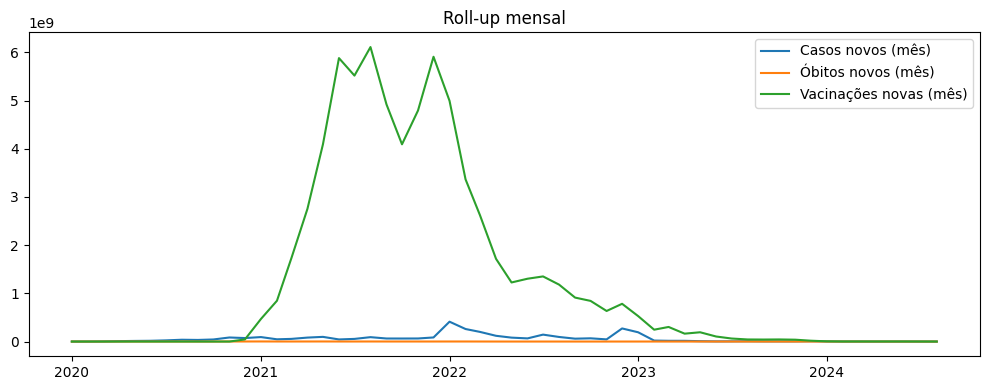

In [41]:
# Roll-up mensal
tmp = fact_covid_daily.merge(dim_date[["date_sk","date","year","month"]], on="date_sk", how="left")
m = tmp.groupby(["year","month"])[["new_cases","new_deaths","new_vaccinations"]].sum().reset_index()
m["ym"] = pd.to_datetime(m["year"].astype(str) + "-" + m["month"].astype(str) + "-01")

plt.figure(figsize=(10,4))
plt.plot(m["ym"], m["new_cases"], label="Casos novos (mês)")
plt.plot(m["ym"], m["new_deaths"], label="Óbitos novos (mês)")
plt.plot(m["ym"], m["new_vaccinations"], label="Vacinações novas (mês)")
plt.legend(); plt.title("Roll-up mensal"); plt.tight_layout(); plt.show()


In [42]:
# Clustering por dia com features padronizadas
daily = fact_covid_daily.copy()
features = ["new_cases","new_deaths","new_vaccinations"]
X = daily[features].fillna(0)

In [43]:
X_scaled = StandardScaler().fit_transform(X)
km = KMeans(n_clusters=4, n_init=20, random_state=42).fit(X_scaled)
labels = km.labels_


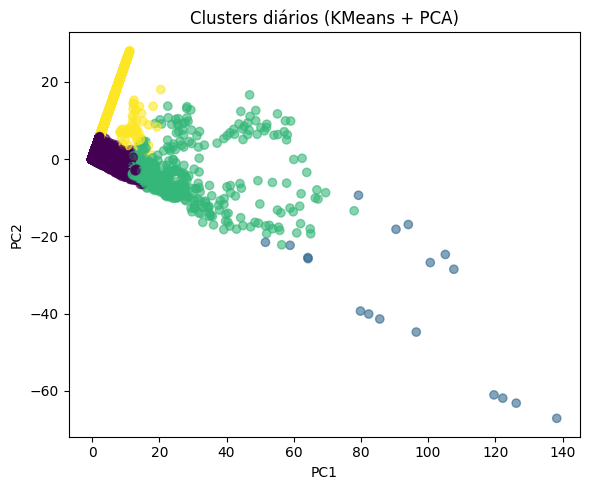

In [44]:
# PCA
coords = PCA(n_components=3, random_state=42).fit_transform(X_scaled)
plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1], c=labels, alpha=0.6)
plt.title("Clusters diários (KMeans + PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

## Exercícios
Realize os seguintes exercícios a partir do **Data Warehouse de COVID-19** que você acabou de construir:

1. **Exploração de dados**
   - Calcule e plote a **média diária** de `new_cases` e `new_deaths` apenas para dias que foram feriados (`is_holiday=True`).  
   - Compare com a média dos demais dias. O que você observa?

2. **Análises OLAP-like**
   - Faça um **roll-up mensal** para calcular a **taxa de letalidade** (`new_deaths / new_cases`) ao longo de 2020.  
   - Realize um **drill-down** para ver a mesma taxa semana a semana em dois meses críticos (ex.: março e abril de 2021).

3. **Medidas adicionais**
   - Crie uma nova métrica chamada `cases_per_million` utilizando os valores de população de `dim_location`.  
   - Plote a evolução mensal dessa métrica.

4. **Clusterização**
   - Aplique o algoritmo **K-Means** considerando agora as features: `new_cases`, `new_deaths`, `new_vaccinations` **e** `stringency_index`.  
   - Compare os resultados (silhouette score e visualização em PCA) com os clusters anteriores.  
   - Interprete os perfis encontrados: quais grupos de dias aparecem?

5. **Discussão**
   - Quais limitações você enxerga nesse modelo de DW para análises de saúde pública?  
   - Que **novas dimensões** poderiam ser adicionadas (ex.: região, faixa etária, comorbidades) para enriquecer as análises?
